## Dose Response Curve Fitting in Python


retreived from: https://gist.github.com/yannabraham/5f210fed773785d8b638?permalink_comment_id=1713810#file-doseresponsepython-ipynb 

In [6]:
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
def front(self, n):
    return self.iloc[:, :n]

def back(self, n):
    return self.iloc[:, -n:]

pd.DataFrame.front = front
pd.DataFrame.back = back

pd.set_option('display.max_columns', 50)

In [8]:
import warnings

def action_with_warnings():
    warnings.warn("should not appear")

In [9]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

### Load the data

In [10]:
BaseDir = "results"
OutputDir = 'dose-response'

if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

In [11]:
df = pd.read_csv('{}/colo44_cleaned_data.csv'.format(BaseDir), sep=';' , index_col=0)


In [12]:
# Add a plate identifier
listOfPlates = df['barcode'].unique()

for i in range(len(listOfPlates)):
    df.loc[df['barcode'] == listOfPlates[i], 'plate'] = int(i)

# Add the log concentration column
df['logConc'] = pDose(df.conc)
df.back(27).head(1)

,site,ImageID,barcode,plate_well,batch_id,solvent,stock_conc,stock_conc_unit,cmpd_vol,cmpd_vol_unit,well_vol,well_vol_unit,pert_type,cmpd_conc,cmpd_conc_unit,batchid,cbkid,libid,libtxt,smiles,inchi,inkey,conc,compound,Count_nuclei,plate,logConc
0,1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02_1,colo44-v1-FA-P017365-CACO2-48h-P1-L1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02,PHB000015,dmso,10.0,mM,7.5,nL,30,uL,poscon,2.5,uM,PHB000015,[tetr],[tetr],pharmb_io,NaN,NaN,NaN,2.5,[tetr],74.0,0.0,5.60206


In [13]:
# Remove the reference compounds for now
dfPert = df[df.pert_type == 'trt']
dfDMSO = df[df['compound'] == '[dmso]']


## Plot dose responses in scatter

In [14]:
features = ['Count_nuclei','ObjectNumber_cells','ObjectNumber_nuclei']

#### Do not change anything from before

In [15]:
dfViability = ((dfPert[features] / dfDMSO[features].mean()) * 100)
dfViability = dfViability.join(dfPert[['barcode', 'conc', 'compound', 'plate','logConc']])

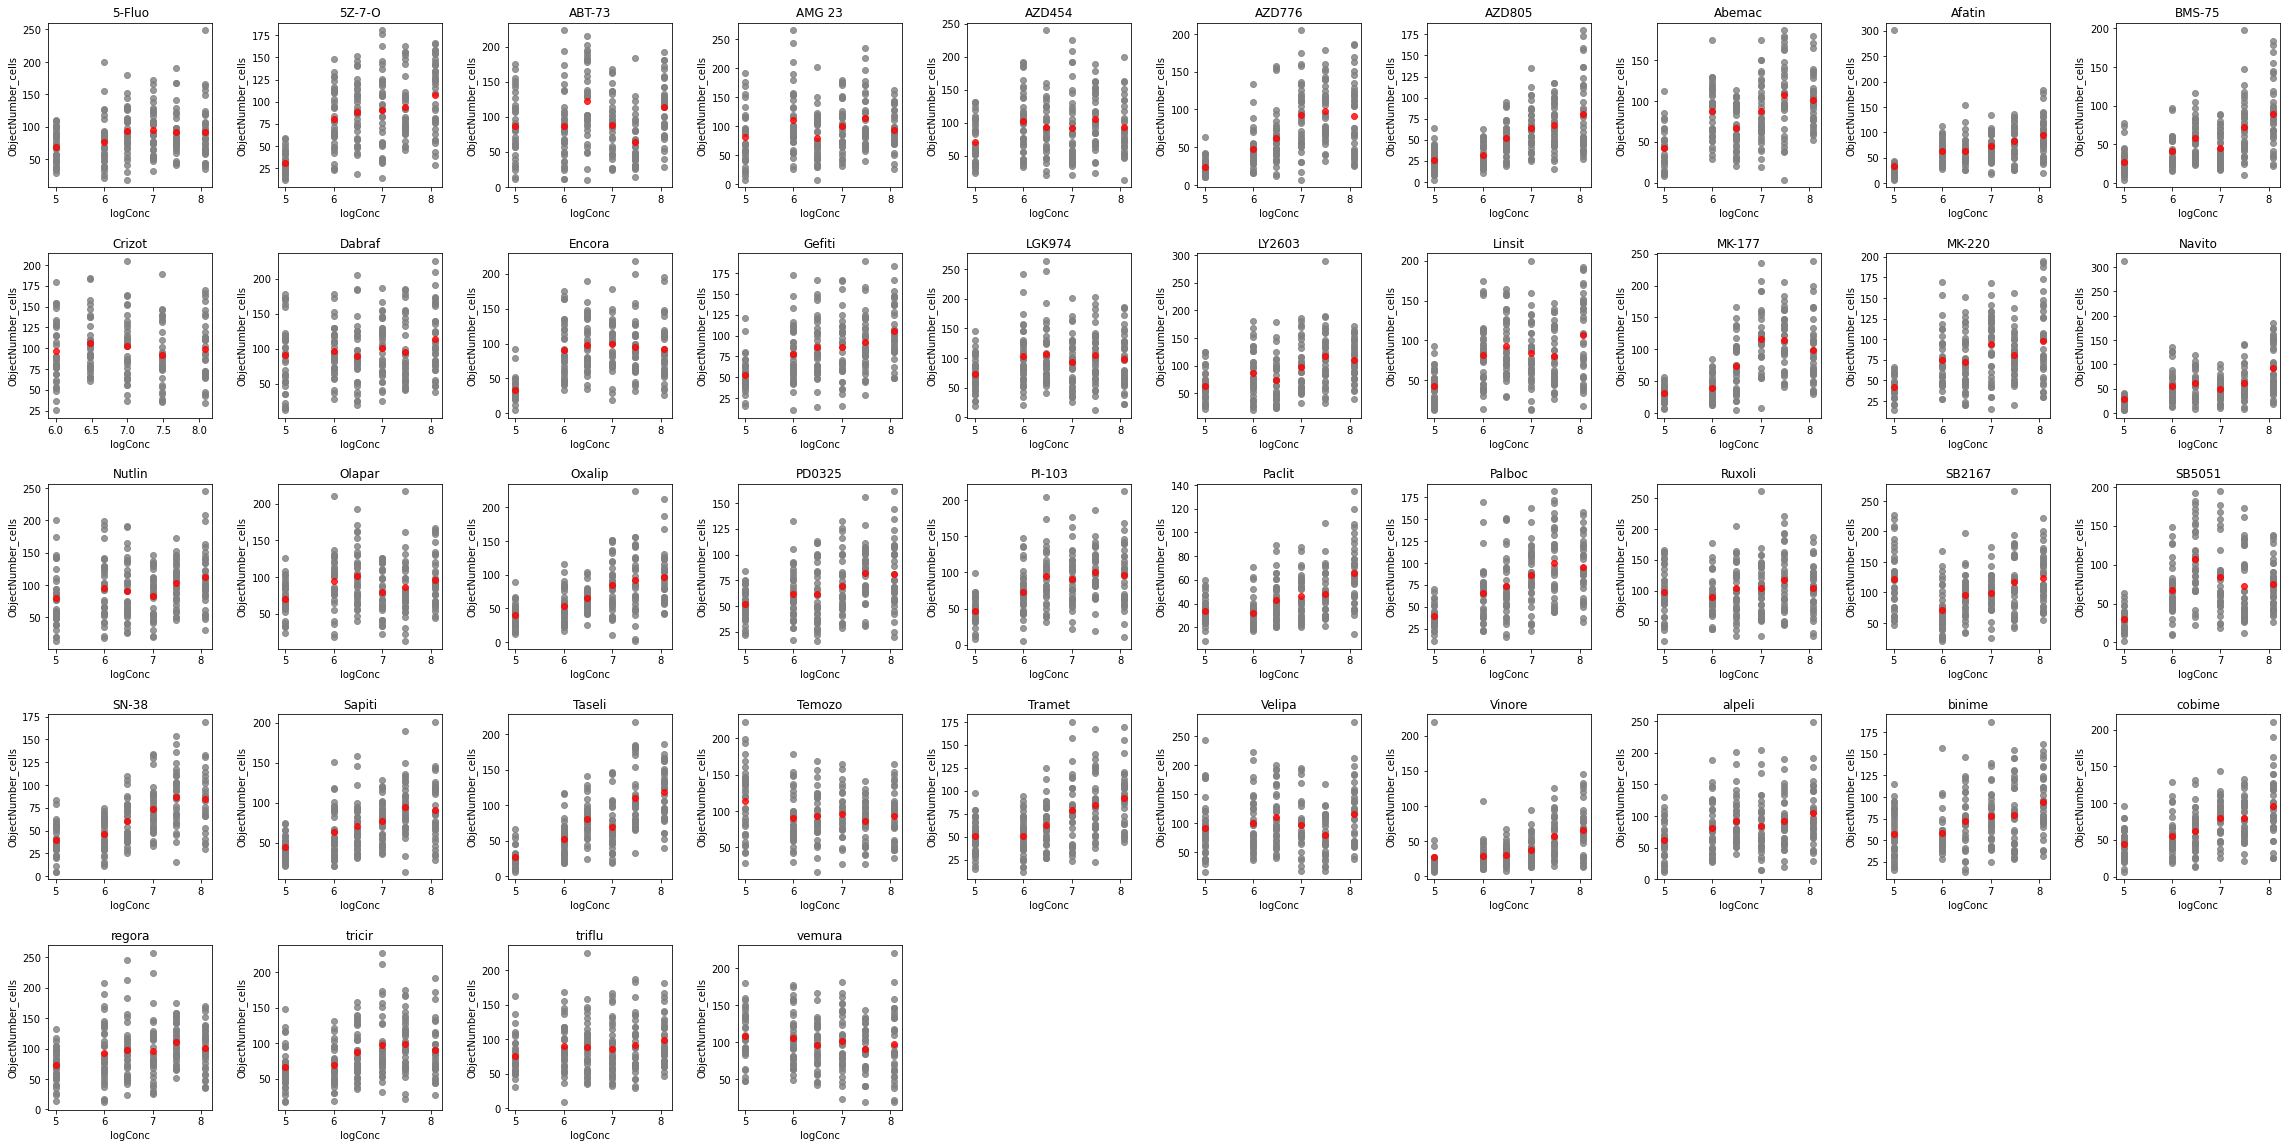

In [16]:
compoundData = dfViability.groupby(['compound'])

nrrow = 5 
nrcol = 10
sp = 1

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('conc').mean()
    #with warnings.catch_warnings():
        #warnings.simplefilter('ignore')
        #mean = meandata.append(meanDMSO,ignore_index=True)

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    #sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=dfDMSO,color='gray', fit_reg=False) # add the DMSO data
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=meandata,color='red', fit_reg=False) # add the mean data
    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

#### Take the average per well

In [17]:
dfPert_well_average = dfPert.groupby(['plate_well']).mean()
dfDMSO_well_average = dfDMSO.groupby(['plate_well']).mean()

In [28]:
dfViability = ((dfPert_well_average[features] / dfDMSO_well_average[features].mean()) * 100)
#dfViability = dfViability.merge(dfPert_well_average[['barcode', 'conc', 'compound', 'plate','logConc']])
dfViability = pd.merge(left=dfViability, right=dfPert[['barcode', 'conc', 'compound', 'plate','logConc','plate_well']], how = 'left', on='plate_well')
dfViability = dfViability.drop_duplicates()

In [123]:
listOfConc = dfViability['conc'].unique()
listOfConc = list(map(str,listOfConc))

In [127]:
listOfConc = ['0.001','0.01','0.1','1.0','10', '100']
listOfConc.reverse()

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/967633354.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/967633354.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/967633354.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/967633354.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/967633354.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/i

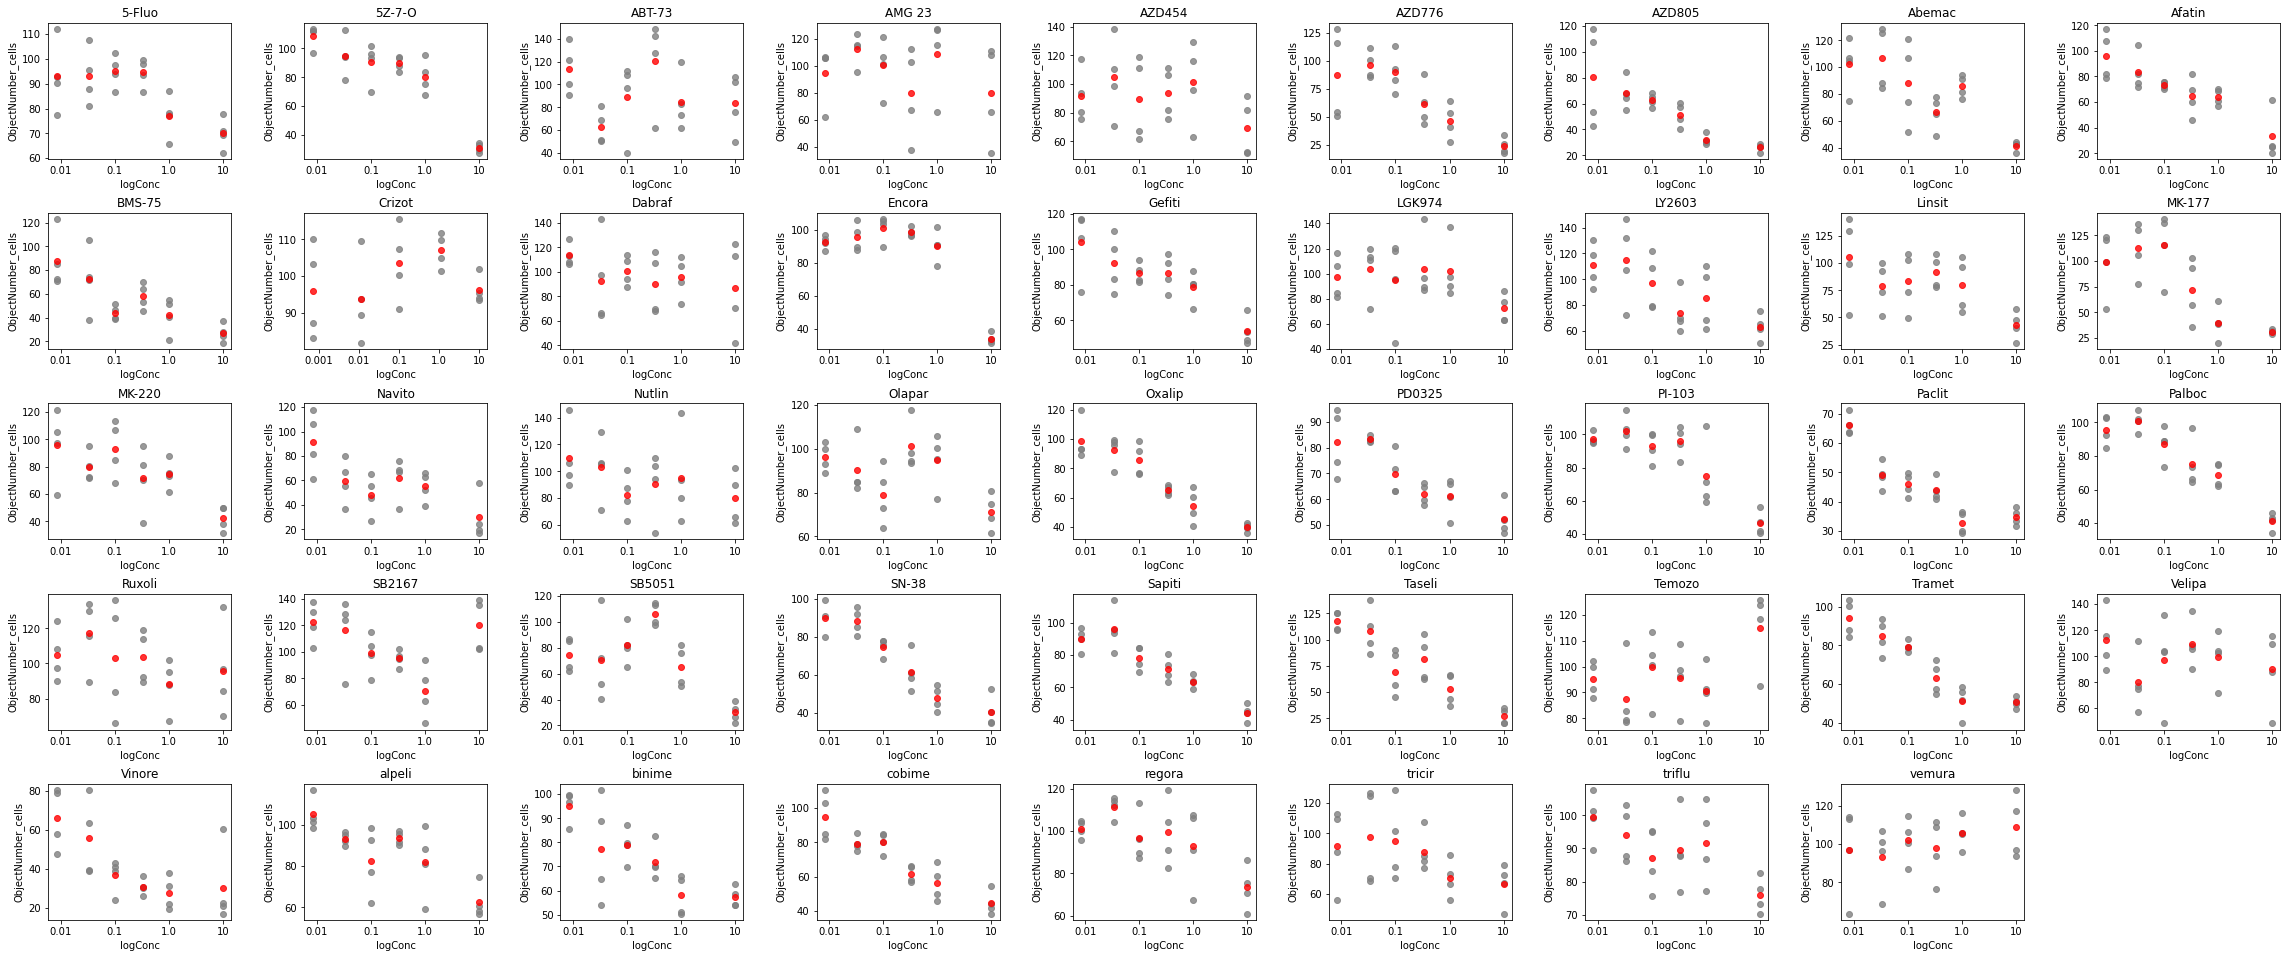

In [128]:
compoundData = dfViability.groupby(['compound'])

nrrow = 6 
nrcol = 9
sp = 1

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('conc').mean()

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=meandata,color='red', fit_reg=False) # add the mean data
    plt.gca().invert_xaxis()
    ax.set_xticklabels(listOfConc)
    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

#### Only divide by DMSO from the same plate

In [30]:
dfPert_well_average = dfPert.groupby(['plate_well']).mean()
dfDMSO_well_average = dfDMSO.groupby(['plate_well']).mean()

In [ ]:
dfViability = pd.DataFrame([])

for OnePlate in range(len(listOfPlates)):
    dfViability = dfViability.append((dfPert_well_average[features].loc[(dfPert_well_average['plate'] == OnePlate)] / dfDMSO_well_average[features].loc[(dfDMSO_well_average['plate'] == OnePlate)].mean())*100)


In [96]:
dfViability = pd.merge(left=dfViability, right=dfPert[['barcode', 'conc', 'compound', 'plate','logConc','plate_well']], how = 'left', on='plate_well')
dfViability = dfViability.drop_duplicates()

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000g

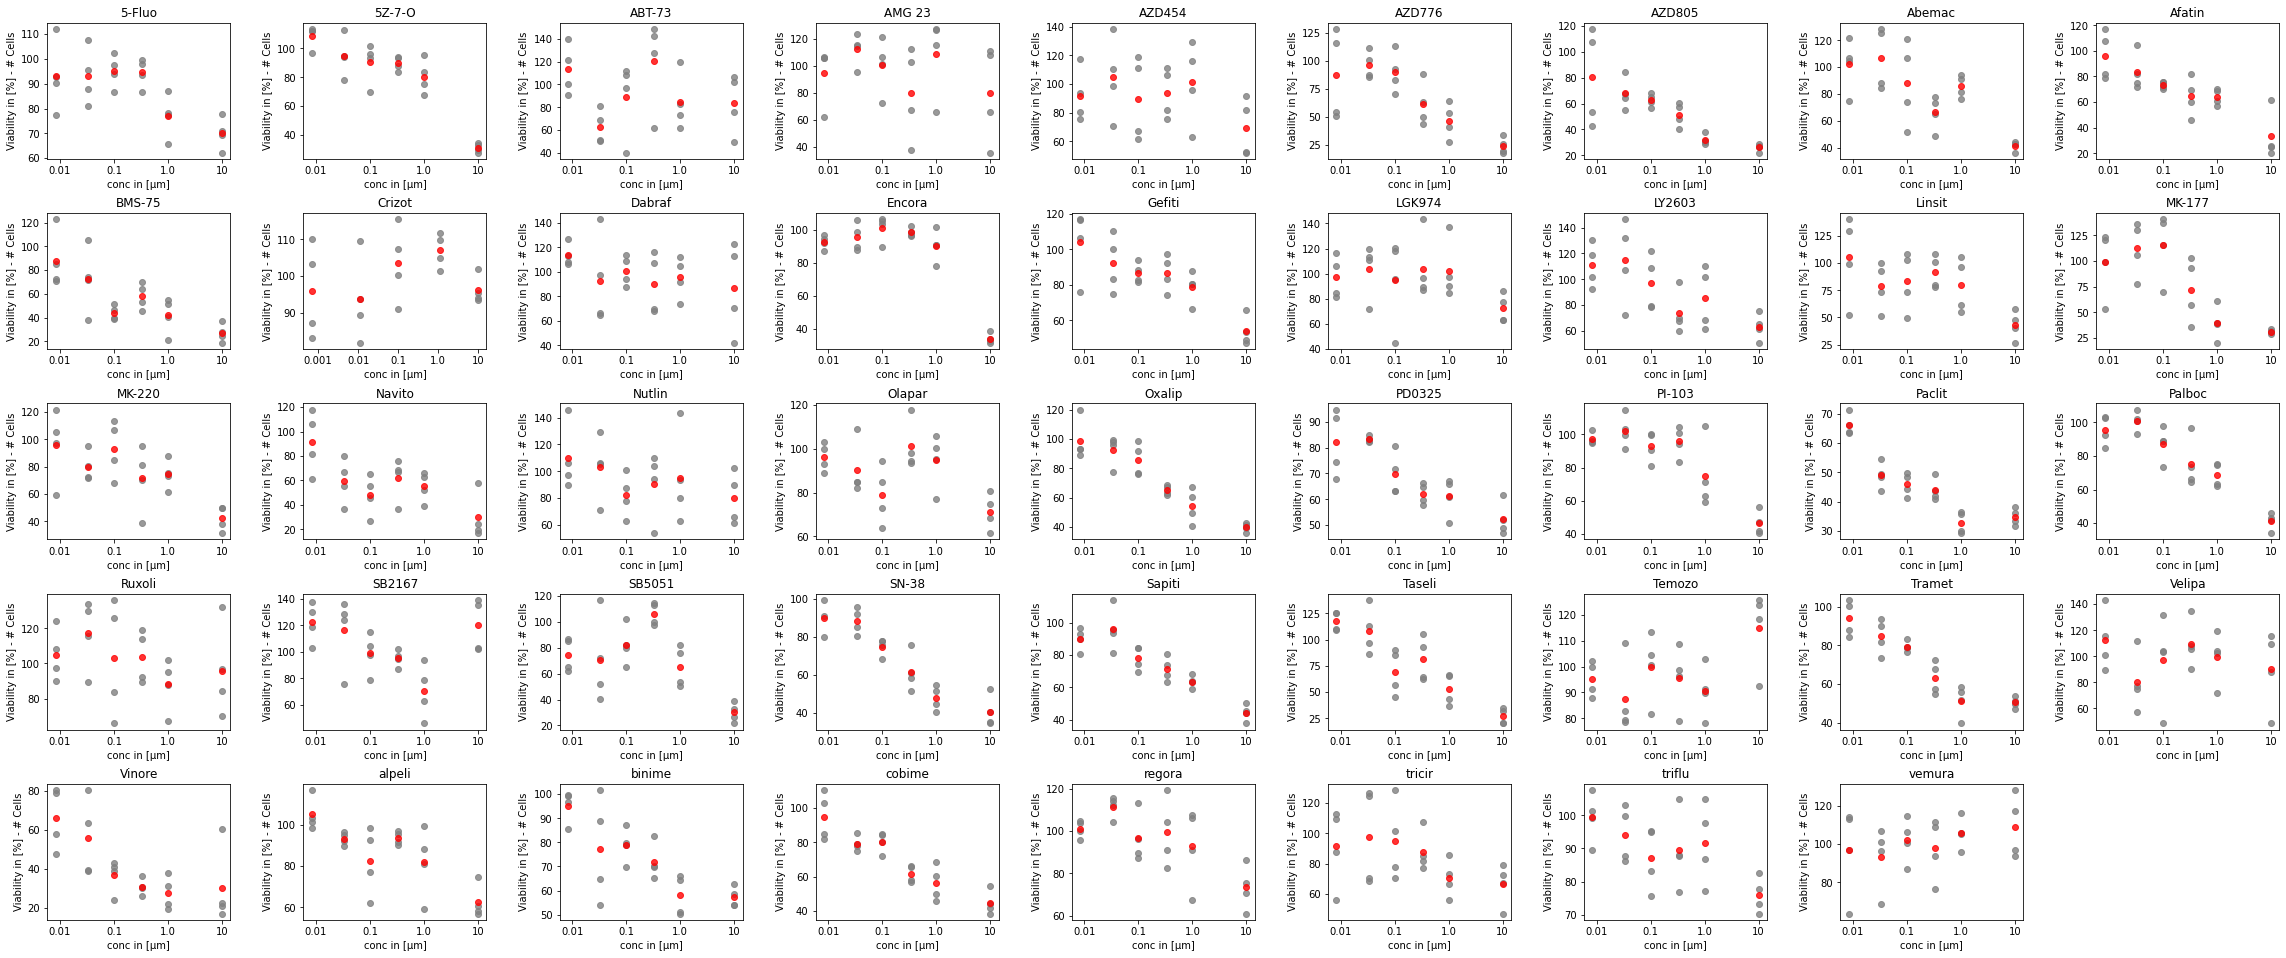

In [132]:
compoundData = dfViability.groupby(['compound'])

nrrow = 6 
nrcol = 9
sp = 1

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('conc').mean()

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=meandata,color='red', fit_reg=False) # add the mean data
    plt.gca().invert_xaxis()
    ax.set_xticklabels(listOfConc)
    ax.set_xlabel('conc in [µm]')
    ax.set_ylabel('Viability in [%] - # Cells')
    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

#### Dose reponse curves on loess normalized plates

In [ ]:
dfPert = df[df.pert_type == 'trt']

In [ ]:
dfPert_well_average = dfPert.groupby(['plate_well']).mean()
dfDMSO_well_average = dfDMSO.groupby(['plate_well']).mean()

In [ ]:
dfViability = pd.DataFrame([])

for OnePlate in range(len(listOfPlates)):
    for feat in features:
        dfViability = dfViability.append((dfPert_well_average[feat].loc[(dfPert_well_average['plate'] == OnePlate)] / dfDMSO_well_average[feat].loc[(dfDMSO_well_average['plate'] == OnePlate)].mean())*100)


In [ ]:
dfViability = pd.merge(left=dfViability, right=dfPert[['barcode', 'conc', 'compound', 'plate','logConc','plate_well']], how = 'left', on='plate_well')
dfViability = dfViability.drop_duplicates()

In [ ]:
compoundData = dfViability.groupby(['compound'])

nrrow = 6 
nrcol = 9
sp = 1

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('conc').mean()

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=meandata,color='red', fit_reg=False) # add the mean data
    plt.gca().invert_xaxis()
    ax.set_xticklabels(listOfConc)
    ax.set_xlabel('conc in [µm]')
    ax.set_ylabel('Viability in [%] - # Cells')
    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

## Fitting the curve
is as simple as

In [184]:
compoundData = dfViability.groupby(['compound'])
fitData = []
for name,group in compoundData:
    try:
        fitCoefs, covMatrix = opt.curve_fit(ll4, group.conc, group.ObjectNumber_cells)
        resids = group.ObjectNumber_cells-group.conc.apply(lambda x: ll4(x,*fitCoefs))
        curFit = dict(zip(['b','c','d','e'],fitCoefs))
        curFit['compound']=name
        curFit['residuals']=sum(resids**2)
        fitData.append(curFit)
    except: 
        print('The fit failed')
fitCompound = [item['compound'] for item in fitData]

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/3180035174.py:7: RuntimeWarning: invalid value encountered in log
  return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))


The fit failed


/Users/chririn/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed
The fit failed


In [185]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,b,c,d,e,residuals
compound,,,,,
5-Fluo,14.883219,70.004502,93.959755,9.438595e-01,1600.988171
ABT-73,20.664641,83.476228,96.270443,8.861383e-01,22226.608929
AMG 23,5.960215,-54.941861,99.251184,1.386441e+01,15577.557850
AZD454,8.325193,67.795842,96.090061,7.185071e+00,11369.153027
AZD776,1.309941,24.141678,93.746264,4.659183e-01,8933.731286
AZD805,0.841703,22.499381,81.359745,2.378582e-01,5291.940420
Dabraf,8.111231,93.303871,218.468572,6.794229e-03,12146.503920
Encora,13.576025,34.232964,96.817174,1.170901e+00,954.389206
LGK974,8.046422,71.140042,100.341719,6.808868e+00,10484.195874


fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

In [190]:
dfFit = dfViability.loc[dfViability['compound'].isin(fitTable.index.unique())]

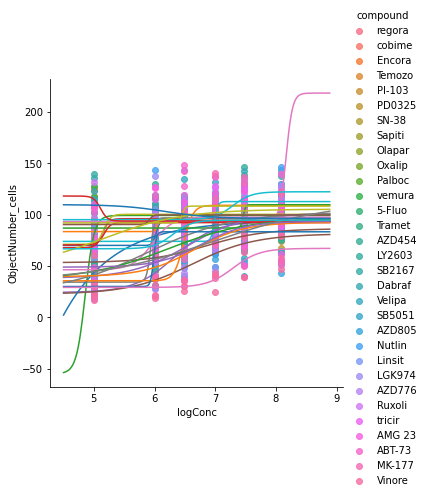

In [191]:
refDose = np.linspace(min(dfFit.logConc)*0.9,max(dfFit.logConc)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot(x='logConc',y='ObjectNumber_cells',data=dfFit,hue='compound',fit_reg=False)
for fit in fitData:
    plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])

In [216]:

dfFit[dfFit['compound'] == fitData[ii].get('compound')]

,plate_well,Count_nuclei,ObjectNumber_cells,ObjectNumber_nuclei,barcode,conc,compound,plate,logConc
217,colo44-v1-FA-P017365-CACO2-48h-P1-L1_C11,98.702017,106.154698,93.789201,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.10000,vemura,0.0,7.000000
300,colo44-v1-FA-P017365-CACO2-48h-P1-L1_C23,67.406912,63.749865,70.572769,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.00833,vemura,0.0,8.079355
663,colo44-v1-FA-P017365-CACO2-48h-P1-L1_F07,100.303099,96.868241,99.133597,colo44-v1-FA-P017365-CACO2-48h-P1-L1,10.00000,vemura,0.0,5.000000
812,colo44-v1-FA-P017365-CACO2-48h-P1-L1_G05,97.948567,105.405957,100.404723,colo44-v1-FA-P017365-CACO2-48h-P1-L1,1.00000,vemura,0.0,6.000000
926,colo44-v1-FA-P017365-CACO2-48h-P1-L1_G19,114.901203,117.053025,108.343349,colo44-v1-FA-P017365-CACO2-48h-P1-L1,10.00000,vemura,0.0,5.000000
989,colo44-v1-FA-P017365-CACO2-48h-P1-L1_H05,87.651410,94.008470,86.039589,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.33300,vemura,0.0,6.477556
1241,colo44-v1-FA-P017365-CACO2-48h-P1-L1_I20,113.645452,112.976551,111.670011,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.00833,vemura,0.0,8.079355
1372,colo44-v1-FA-P017365-CACO2-48h-P1-L1_J14,84.072520,76.621063,80.293536,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.33300,vemura,0.0,6.477556
1476,colo44-v1-FA-P017365-CACO2-48h-P1-L1_K08,108.591055,101.329484,105.923958,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.03330,vemura,0.0,7.477556
1599,colo44-v1-FA-P017365-CACO2-48h-P1-L1_L04,105.294709,106.071504,106.680018,colo44-v1-FA-P017365-CACO2-48h-P1-L1,1.00000,vemura,0.0,6.000000


#### TODO: 
Set a threshold on which cutoffs to use!

In [223]:
feature = 'ObjectNumber_cells'

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1763466747.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)


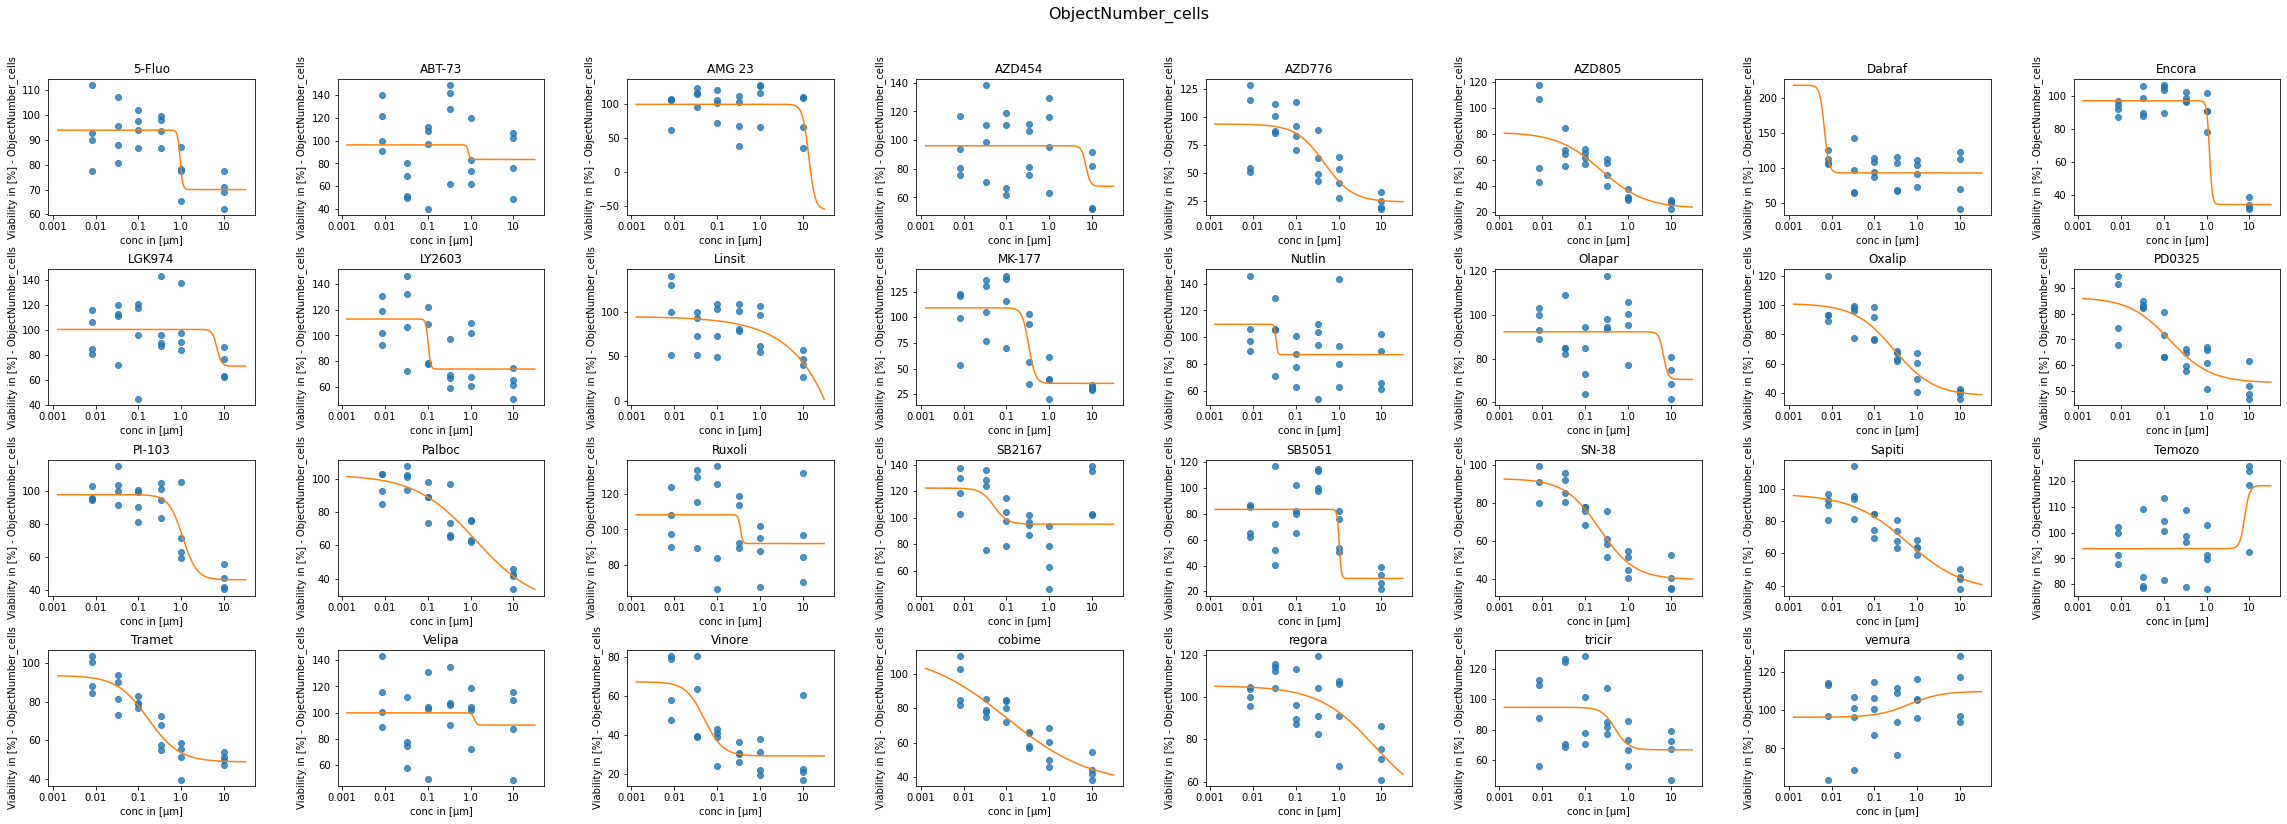

In [231]:
refDose = np.linspace(min(dfFit.logConc)*0.9,max(dfFit.logConc)*1.1,256)
refDose = (10**-refDose)*1e6

nrrow = 6 
nrcol = 8
sp = 1

fig = plt.figure(figsize = (40,20))
fig.suptitle('{}'.format(feature), fontsize = 16, y=0.93)

for ii in range(len(fitData)):
    ax = fig.add_subplot(nrrow, nrcol, sp)
    sns.regplot(ax=ax, x='logConc',y=feature,data=dfFit[dfFit['compound'] == fitData[ii].get('compound')],fit_reg=False)
    fit = fitData[ii]
    plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])
    ax.set_title(fitData[ii].get('compound'))
    plt.gca().invert_xaxis()
    ax.set_xticklabels(listOfConc)
    ax.set_xlabel('conc in [µm]')
    ax.set_ylabel('Viability in [%] - ' + feature)
    sp += 1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

## MAD normalized plates

In [242]:
# dfNormalized = pd.read_csv('{}/colo44_MAD_normalized.csv'.format(BaseDir), sep=';' , index_col=0)
# dfNormalized['logConc'] = pDose(dfNormalized.conc)

In [250]:
# listOfPlates = dfNormalized['barcode'].unique()

# for i in range(len(listOfPlates)):
#     dfNormalized.loc[dfNormalized['barcode'] == listOfPlates[i], 'plate'] = int(i)

In [269]:
# # Remove the reference compounds for now
# dfPert = dfNormalized[dfNormalized.pert_type == 'trt'].set_index('plate_well')
# dfDMSO = dfNormalized[dfNormalized['compound'] == '[dmso]'].set_index('plate_well')

In [271]:
# dfViability = ((dfPert[features] / dfDMSO[features].mean()) * 100)
# #dfViability = dfViability.merge(dfPert_well_average[['barcode', 'conc', 'compound', 'plate','logConc']])
# dfViability = pd.merge(left=dfViability, right=dfPert[['barcode', 'conc', 'compound', 'plate','logConc']], how = 'left', on='plate_well')
# dfViability = dfViability.drop_duplicates()

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_59049/1299873198.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000g

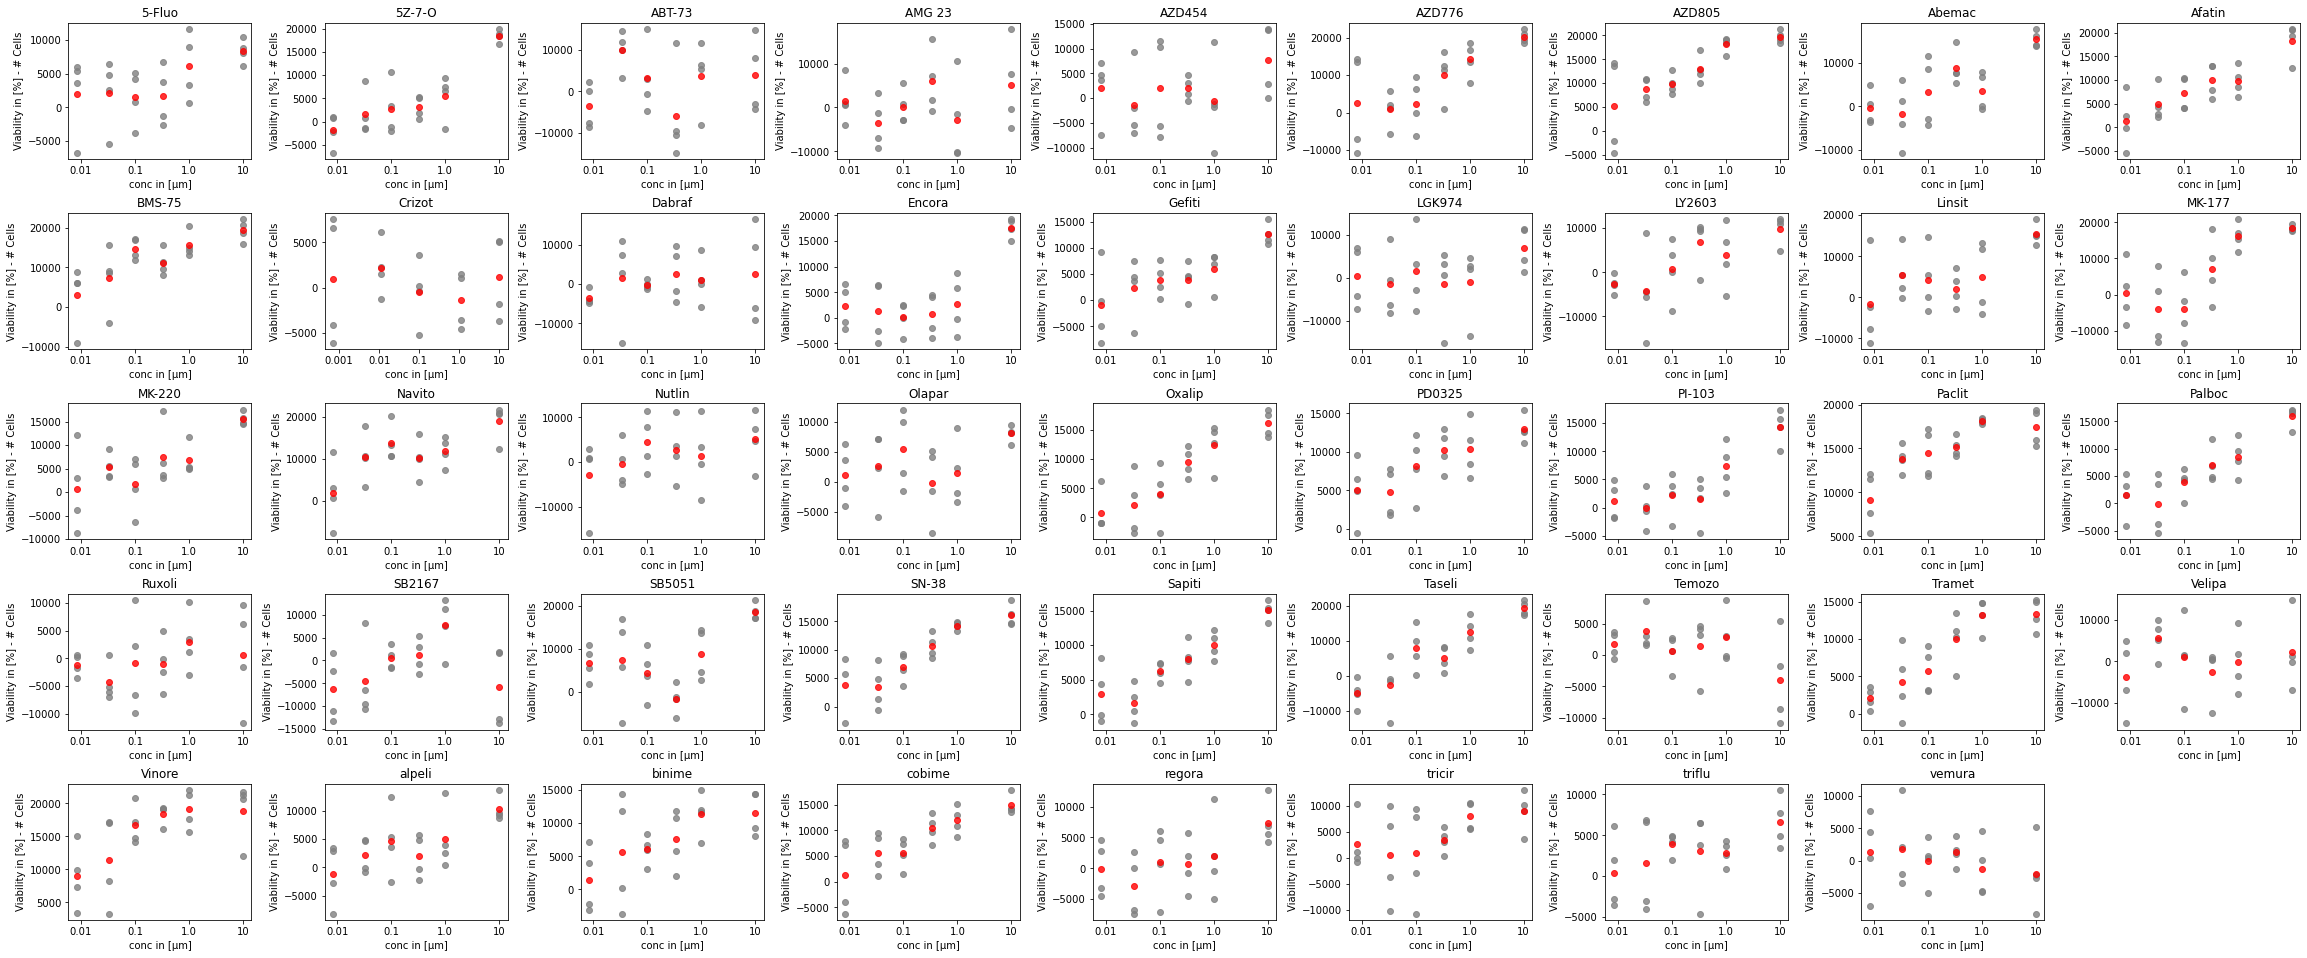

In [272]:
# compoundData = dfViability.groupby(['compound'])

# nrrow = 6 
# nrcol = 9
# sp = 1

# fig = plt.figure(figsize = (40,20))
# for compound in compoundData:

#     meandata = compound[1].groupby('conc').mean()

#     ax = fig.add_subplot(nrrow, nrcol, sp)
#     ax.set_title(compound[0])
#     sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
#     sns.regplot(ax=ax, x='logConc',y='ObjectNumber_cells',data=meandata,color='red', fit_reg=False) # add the mean data
#     plt.gca().invert_xaxis()
#     ax.set_xticklabels(listOfConc)
#     ax.set_xlabel('conc in [µm]')
#     ax.set_ylabel('Viability in [%] - # Cells')
#     sp +=1
# plt.subplots_adjust( wspace=0.4, hspace=0.4)

#### LOESS normalized plates

## Plotting my own data

In [ ]:
dfDMSO['logConc']  = dfDMSO.conc  * 90
dfDMSO.head()

In [ ]:
compoundData = dfViability.groupby(['compound'])

nrrow = 5 
nrcol = 10
sp = 1

meanDMSO = dfDMSO[['conc','Count_nuclei', 'ObjectNumber_cells', 'logConc']].mean()

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('conc').mean()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        mean = meandata.append(meanDMSO,ignore_index=True)

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=dfDMSO,color='gray', fit_reg=False) # add the DMSO data
    sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=mean,color='red', fit_reg=False) # add the mean data
    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

## Fit one compound at a time

In [ ]:
cmpd = 1 # Select which compound
name = compoundList[cmpd]
print(name)

In [ ]:
#compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.conc, group.Count_nuclei)
    resids = group.Count_nuclei-group.conc.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]

In [ ]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

In [ ]:
params = [{'compound':'5Z-7-O', 'b':1, 'c':0, 'd':100, 'e':0.4,'startDose':10, 'nDose':8, 'dilution':3},]
paramsCompound = [item['compound'] for item in params]

In [ ]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)